In [1]:
def get_all_categories(dataset_path):
    category_list = []
    for file in os.listdir(dataset_path+"labels"):
        with open(dataset_path+"labels/"+file, "r") as stream:
            label = yaml.safe_load(stream)
        for category in label['labels']:
            if category not in category_list:
                category_list.append(category)
    return category_list

In [2]:
import yaml
from detectron2.structures import BoxMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import cv2

def get_dataset_dicts(dataset_path, category_list):
    dataset_dicts = []
    for file in os.listdir(dataset_path+"labels"):
        record = {}
        with open(dataset_path+"labels/"+file, "r") as stream:
            try:
                label = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        filename = dataset_path+"images/"+file.split(".")[0]+".JPEG"
        height, width = cv2.imread(filename).shape[:2]
        # width, height  = label['image_size'][0], label['image_size'][1]
        record["file_name"] = filename
        record["image_id"] = int(file.split(".")[0])
        record["height"] = height
        record["width"] = width
        
        objs = []
        for i in range(len(label['bboxes'])):
            box = label['bboxes'][i]
            category = label['labels'][i]
            category_id = category_list.index(category)
            obj = {
                "bbox": box,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

category_list = get_all_categories("../labeled_data/training/")
for d in ["../labeled_data/training/", "../labeled_data/validation/"]:
    DatasetCatalog.register(d, lambda d=d: get_dataset_dicts(d, category_list))
    MetadataCatalog.get( d).set(thing_classes=category_list)
balloon_metadata = MetadataCatalog.get("../labeled_data/training/")
        

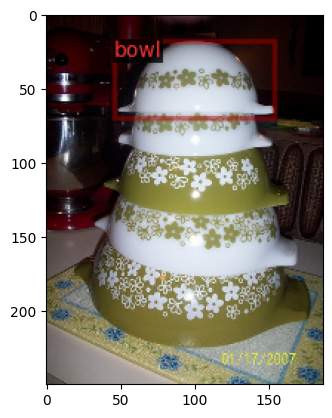

In [3]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt

dataset_dicts = get_dataset_dicts("../labeled_data/validation/", category_list)
for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.savefig('myfilename.png', dpi=100)
    plt.show()

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

In [4]:
len(category_list)

100

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml"))
cfg.DATASETS.TRAIN = ("../labeled_data/training/",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("PascalVOC-Detection/faster_rcnn_R_50_C4.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 100  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/08 19:02:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (21, 2048) in the checkpoint but (101, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (21,) in the checkpoint but (101,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (80, 2048) in the checkpoint but (400, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (400,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bi

[11/08 19:04:00 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\chang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/08 19:04:11 d2.utils.events]:  eta: 0:03:14  iter: 19  total_loss: 5.249  loss_cls: 4.43  loss_box_reg: 0.6903  loss_rpn_cls: 0.1008  loss_rpn_loc: 0.09239  time: 0.2030  data_time: 0.1843  lr: 4.7702e-05  max_mem: 2124M
[11/08 19:04:15 d2.utils.events]:  eta: 0:03:13  iter: 39  total_loss: 3.673  loss_cls: 2.776  loss_box_reg: 0.7296  loss_rpn_cls: 0.06485  loss_rpn_loc: 0.1082  time: 0.2051  data_time: 0.0010  lr: 9.7652e-05  max_mem: 2201M
[11/08 19:04:19 d2.utils.events]:  eta: 0:03:11  iter: 59  total_loss: 1.975  loss_cls: 1.069  loss_box_reg: 0.7373  loss_rpn_cls: 0.04812  loss_rpn_loc: 0.08625  time: 0.2049  data_time: 0.0010  lr: 0.0001476  max_mem: 2201M
[11/08 19:04:23 d2.utils.events]:  eta: 0:03:06  iter: 79  total_loss: 1.716  loss_cls: 0.8678  loss_box_reg: 0.654  loss_rpn_cls: 0.05533  loss_rpn_loc: 0.08219  time: 0.2042  data_time: 0.0010  lr: 0.00019755  max_mem: 2201M
[11/08 19:04:27 d2.utils.events]:  eta: 0:03:02  iter: 99  total_loss: 1.863  loss_cls: 0.9646  

In [6]:
%load_ext tensorboard
%tensorboard --logdir output

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [10]:
from detectron2.engine import DefaultPredictor
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = "output/model_final.pth"
print(cfg.MODEL.WEIGHTS)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

output/model_final.pth
[11/08 19:08:05 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,nor

In [16]:
dataset_dicts = get_dataset_dicts("../labeled_data/validation/", category_list)

In [17]:
from detectron2.utils.visualizer import ColorMode
# dataset_dicts = get_dataset_dicts("../labeled_data/validation/", category_list)
for d in random.sample(dataset_dicts, 1):    
    im = plt.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.savefig('myfilename.png', dpi=100)
    plt.show()

C:\Users\chang\AppData\Local\Temp\ipykernel_7396\1811746217.py:14: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("../labeled_data/validation/", output_dir="output")
val_loader = build_detection_test_loader(cfg, "../labeled_data/validation/")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[11/08 19:13:22 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[11/08 19:13:22 d2.evaluation.coco_evaluation]: Trying to convert '../labeled_data/validation/' to COCO format ...
[11/08 19:13:22 d2.data.datasets.coco]: Converting annotations of dataset '../labeled_data/validation/' to COCO format ...)
[11/08 19:14:23 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[11/08 19:14:27 d2.data.datasets.coco]: Conversion finished, #images: 20000, #annotations: 27584
[11/08 19:14:27 d2.data.datasets.coco]: Caching COCO format annotations at 'output\../labeled_data/validation/_coco_format.json' ...
[11/08 19:15:29 d2.data.build]: Distribution of instances among all 100 categories:
|   category    | #instances   |  category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-------------:|:-------------|
|     cart      | 211          |   person    | 3096         |     

TypeError: 'numpy.float64' object cannot be interpreted as an integer